In [77]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
plt.style.use('dark_background')
%matplotlib inline

In [78]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [79]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.transpose(1, 2, 0)
X_test = X_test.transpose(1, 2, 0)
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])

num_labels = len(np.unique(y_train))
num_features = X_train.shape[0]
num_samples = X_train.shape[1]

# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train).T
Y_test = tf.keras.utils.to_categorical(y_test).T


# Normalize the samples (images)
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)

print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


In [80]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

In [81]:
## Define the loss function and its gradient
def cce(Y, Yhat):
  return(np.mean(np.sum(-Y*np.log(Yhat), axis = 0)))
  #TensorFlow in-built function for categorical crossentropy loss
  #cce = tf.keras.losses.CategoricalCrossentropy()
  #return(cce(Y, Yhat).numpy())

def cce_gradient(Y, Yhat):
  return(-Y/Yhat)

In [82]:
class Activation(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return(self.output)

    def backward(self, output_gradient, learning_rate = None):
        return(output_gradient * self.activation_gradient(self.input))

In [83]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1 - a)

        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)

        def tanh_gradient(z):
            return 1 - np.tanh(z) ** 2

        super().__init__(tanh, tanh_gradient)

class ReLU(Activation):
    def __init__(self):
        def relu(z):
            return z * (z > 0)

        def relu_gradient(z):
            return 1. * (z > 0)

        super().__init__(relu, relu_gradient)

In [84]:
## Softmax activation layer class
class Softmax(Layer):
  def forward(self, input):
    self.output = tf.nn.softmax(input, axis = 0).numpy()

  def backward(self, output_gradient, learning_rate = None):
    ## Following is the inefficient way of calculating the backward gradient
    softmax_gradient = np.empty((self.output.shape[0], output_gradient.shape[1]), dtype = np.float64)
    for b in range(softmax_gradient.shape[1]):
      softmax_gradient[:, b] = np.dot((np.identity(self.output.shape[0])-np.atleast_2d(self.output[:, b])) * np.atleast_2d(self.output[:, b]).T, output_gradient[:, b])
    return(softmax_gradient)
    ## Following is the efficient way of calculating the backward gradient
    #T = np.transpose(np.identity(self.output.shape[0]) - np.atleast_2d(self.output).T[:, np.newaxis, :], (2, 1, 0)) * np.atleast_2d(self.output)
    #return(np.einsum('jik, ik -> jk', T, output_gradient))

In [85]:
# Dropout layer class
class Dropout(Layer):

    def __init__(self, probability_dropout = 0.0):
        self.probability_dropout = probability_dropout
        self.dropout_matrix = None
    
    def forward(self, input):
        self.dropout_matrix = (np.random.rand(input.shape[0], input.shape[1]) )
        self.dropout_matrix = (self.dropout_matrix < (1 - self.probability_dropout))
        self.output = (input * self.dropout_matrix)/(1 - self.probability_dropout)
        return(self.output)    
        
    def backward(self, output_gradient):
        return(self.dropout_matrix * output_gradient[:-1, :])

In [86]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength):
        self.weights = 0.01*np.random.randn(output_size, input_size+1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None

    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
        # Calculate the regularization loss
        #self.reg_loss = (self.reg_strength)*np.sum((self.weights**2) - (self.weights[:, -1]**2))
        #self.reg_loss = (self.reg_strength)*np.sum((self.weights[:, :-1]*self.weights[:, :-1]))

    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the backward gradient
        '''weights_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        for b in range(output_gradient.shape[1]):
          weights_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
        weights_gradient = (1/output_gradient.shape[1])*weights_gradient'''

        ## Following is the efficient way of calculating the backward gradient
        weights_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
        # add regularization gradient here weights should not contain bias weights
        weights_gradient += 2*self.reg_strength*np.hstack([self.weights[:, :-1], np.zeros((self.weights.shape[0], 1))])
        #weights_gradient += (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)

        input_gradient = np.dot(self.weights.T, output_gradient)

        # Update weights using gradient descent step
        self.weights = self.weights + learning_rate * (-weights_gradient)

        return(input_gradient)

In [87]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

In [88]:
learning_rate = 1e-1 # learning rate
batch_size = 100 # batch size
nepochs = 100 # number of epochs
reg_strength = 0
loss_train_epoch = np.empty(nepochs, dtype = np.float64) # create empty array to store training losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64) # create empty array to store testing losses over each epoch

dlayer1 = Dense(num_features, 128, reg_strength=0) # define dense layer 1
alayer1 = ReLU() # ReLU activation layer 1
dropout1 = Dropout(probability_dropout=0.5)
dlayer2 = Dense(128, num_labels, reg_strength=0) # define dense layer 2
softmax = Softmax() # define softmax activation layer
 
    # Steps: run over each sample in the batch, calculate loss, gradient of loss,
    # and update weights.
 
epoch = 0
while epoch < nepochs:
    batch_indices = generate_batch_indices(num_samples, batch_size)
    loss = 0
    for b in range(len(batch_indices)):
        #Forward Propagation for training data
        dlayer1.forward(X_train[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
        alayer1.forward(dlayer1.output) # forward prop activation layer 1
        dropout1.forward(alayer1.output) # dropout after layer 1
        dlayer2.forward(dropout1.output) # forward prop dense layer 2
        softmax.forward(dlayer2.output) # Softmax activate
        loss += cce(Y_train[:, batch_indices[b]], softmax.output) # calculate training data loss
 
        # Backward propagation for training data starts here
        grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
        grad = softmax.backward(grad)
        grad = dlayer2.backward(grad, learning_rate)
        grad = dropout1.backward(grad)
        grad = alayer1.backward(grad)
        grad = dlayer1.backward(grad, learning_rate)
    # Calculate average training loss for the current epoch
    loss_train_epoch[epoch] = loss/len(batch_indices)
 
    # Forward Propagation for test data
    dlayer1.forward(X_test) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dlayer2.forward(alayer1.output) # forward prop dense layer 2
    softmax.forward(dlayer2.output) # Softmax activate
    # Calculate test data loss and Add regularization loss
    loss_test_epoch[epoch] = cce(Y_test, softmax.output)
 
    print('Epoch %d: training loss = %f test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
    epoch = epoch + 1

Epoch 1: training loss = 0.903290 test loss = 0.358109
Epoch 2: training loss = 0.400976 test loss = 0.269073
Epoch 3: training loss = 0.327169 test loss = 0.223313
Epoch 4: training loss = 0.284980 test loss = 0.194997
Epoch 5: training loss = 0.255048 test loss = 0.173137
Epoch 6: training loss = 0.236351 test loss = 0.158346
Epoch 7: training loss = 0.219333 test loss = 0.146158
Epoch 8: training loss = 0.206388 test loss = 0.137783
Epoch 9: training loss = 0.198606 test loss = 0.130344
Epoch 10: training loss = 0.190184 test loss = 0.124810
Epoch 11: training loss = 0.179603 test loss = 0.119069
Epoch 12: training loss = 0.175838 test loss = 0.115595
Epoch 13: training loss = 0.168504 test loss = 0.111059
Epoch 14: training loss = 0.162381 test loss = 0.108071
Epoch 15: training loss = 0.159396 test loss = 0.105337
Epoch 16: training loss = 0.154286 test loss = 0.102441
Epoch 17: training loss = 0.153495 test loss = 0.099485
Epoch 18: training loss = 0.148230 test loss = 0.098691
E

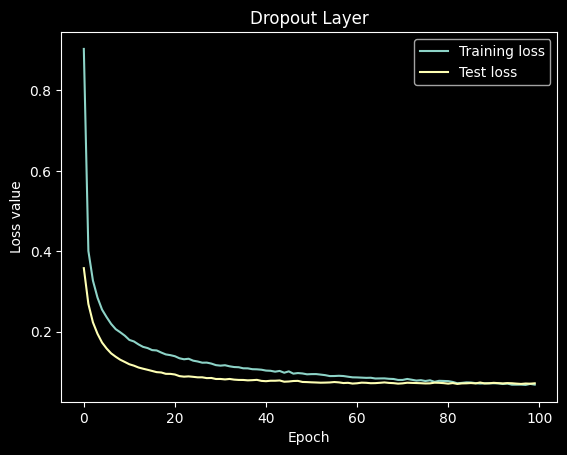

In [89]:
# Plot training loss as a function of epoch:
plt.title("Dropout Layer")
plt.plot(loss_train_epoch, label = 'Training loss')
plt.plot(loss_test_epoch, label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.show()

(1) no regularization

In [90]:
class Activation1(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return(self.output)

    def backward(self, output_gradient, learning_rate = None):
        return(output_gradient[:-1, :] * self.activation_gradient(self.input))

In [91]:
class Sigmoid(Activation1):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1 - a)

        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation1):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)

        def tanh_gradient(z):
            return 1 - np.tanh(z) ** 2

        super().__init__(tanh, tanh_gradient)

class ReLU(Activation1):
    def __init__(self):
        def relu(z):
            return z * (z > 0)

        def relu_gradient(z):
            return 1. * (z > 0)

        super().__init__(relu, relu_gradient)

In [92]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength):
        self.weights = 0.01*np.random.randn(output_size, input_size+1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None

    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
        # Calculate regularization loss
        self.reg_loss = self.reg_strength * np.sum(self.weights[:, :-1] * self.weights[:, :-1])

    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the backward gradient
        #weights_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        #for b in range(output_gradient.shape[1]):
        #  weights_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
        #weights_gradient = (1/output_gradient.shape[1])*weights_gradient

        ## Following is the efficient way of calculating the weights gradient w.r.t. data
        weights_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
        # Add the regularization gradient here
        weights_gradient += 2 * self.reg_strength * np.hstack([self.weights[:, :-1], np.zeros((self.weights.shape[0], 1))])


        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights = self.weights + learning_rate * (-weights_gradient)

        return(input_gradient)

In [93]:
learning_rate = 1e-1 # learning rate
batch_size = 100 # batch size
nepochs = 100 # number of epochs
reg_strength = 0
loss_train_epoch_nr = np.empty(nepochs, dtype = np.float64) # create empty array to store training losses over each epoch
loss_test_epoch_nr = np.empty(nepochs, dtype = np.float64) # create empty array to store testing losses over each epoch

dlayer1 = Dense(num_features, 128, reg_strength=0) # define dense layer 1
alayer1 = ReLU() # ReLU activation layer 1

#dropout1 = Dropout(probability_dropout=0.5)
dlayer2 = Dense(128, num_labels, reg_strength=0) # define dense layer 2
softmax = Softmax() # define softmax activation layer
 
    # Steps: run over each sample in the batch, calculate loss, gradient of loss,
    # and update weights.
 
epoch = 0
while epoch < nepochs:
    batch_indices = generate_batch_indices(num_samples, batch_size)
    loss = 0
    for b in range(len(batch_indices)):
        #Forward Propagation for training data
        dlayer1.forward(X_train[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
        alayer1.forward(dlayer1.output) # forward prop activation layer 1
        #dropout1.forward(alayer1.output) # dropout after layer 1
        dlayer2.forward(alayer1.output) # forward prop dense layer 2
        softmax.forward(dlayer2.output) # Softmax activate
        loss += cce(Y_train[:, batch_indices[b]], softmax.output) # calculate training data loss
 
        # Backward propagation for training data starts here
        grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
        grad = softmax.backward(grad)
        grad = dlayer2.backward(grad, learning_rate)
        #grad = dropout1.backward(grad)
        grad = alayer1.backward(grad)
        grad = dlayer1.backward(grad, learning_rate)
    # Calculate average training loss for the current epoch
    loss_train_epoch_nr[epoch] = loss/len(batch_indices) + dlayer1.reg_loss
 
    # Forward Propagation for test data
    dlayer1.forward(X_test) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dlayer2.forward(alayer1.output) # forward prop dense layer 2
    softmax.forward(dlayer2.output) # Softmax activate
    # Calculate test data loss and Add regularization loss
    loss_test_epoch_nr[epoch] = cce(Y_test, softmax.output) + dlayer2.reg_loss
 
    print('Epoch %d: training loss = %f test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
    epoch = epoch + 1

Epoch 1: training loss = 0.903290 test loss = 0.358109
Epoch 2: training loss = 0.400976 test loss = 0.269073
Epoch 3: training loss = 0.327169 test loss = 0.223313
Epoch 4: training loss = 0.284980 test loss = 0.194997
Epoch 5: training loss = 0.255048 test loss = 0.173137
Epoch 6: training loss = 0.236351 test loss = 0.158346
Epoch 7: training loss = 0.219333 test loss = 0.146158
Epoch 8: training loss = 0.206388 test loss = 0.137783
Epoch 9: training loss = 0.198606 test loss = 0.130344
Epoch 10: training loss = 0.190184 test loss = 0.124810
Epoch 11: training loss = 0.179603 test loss = 0.119069
Epoch 12: training loss = 0.175838 test loss = 0.115595
Epoch 13: training loss = 0.168504 test loss = 0.111059
Epoch 14: training loss = 0.162381 test loss = 0.108071
Epoch 15: training loss = 0.159396 test loss = 0.105337
Epoch 16: training loss = 0.154286 test loss = 0.102441
Epoch 17: training loss = 0.153495 test loss = 0.099485
Epoch 18: training loss = 0.148230 test loss = 0.098691
E

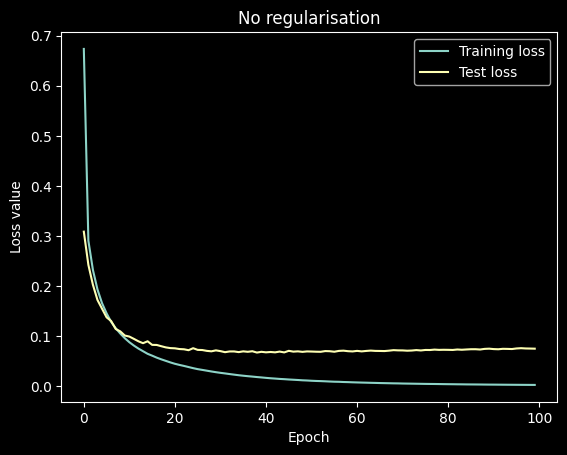

In [94]:
# Plot training loss as a function of epoch:
plt.title("No regularisation")
plt.plot(loss_train_epoch_nr, label = 'Training loss')
plt.plot(loss_test_epoch_nr, label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.show()

loss-based regularization with reg_strength = 0.1

In [95]:
learning_rate = 1e-1 # learning rate
batch_size = 100 # batch size
nepochs = 100 # number of epochs
reg_strength = 0.1
loss_train_epoch_r = np.empty(nepochs, dtype = np.float64) # create empty array to store training losses over each epoch
loss_test_epoch_r = np.empty(nepochs, dtype = np.float64) # create empty array to store testing losses over each epoch

dlayer1 = Dense(num_features, 128, reg_strength=0) # define dense layer 1
alayer1 = ReLU() # ReLU activation layer 1

#dropout1 = Dropout(probability_dropout=0.5)
dlayer2 = Dense(128, num_labels, reg_strength=0) # define dense layer 2
softmax = Softmax() # define softmax activation layer
 
    # Steps: run over each sample in the batch, calculate loss, gradient of loss,
    # and update weights.
 
epoch = 0
while epoch < nepochs:
    batch_indices = generate_batch_indices(num_samples, batch_size)
    loss = 0
    for b in range(len(batch_indices)):
        #Forward Propagation for training data
        dlayer1.forward(X_train[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
        alayer1.forward(dlayer1.output) # forward prop activation layer 1
        #dropout1.forward(alayer1.output) # dropout after layer 1
        dlayer2.forward(alayer1.output) # forward prop dense layer 2
        softmax.forward(dlayer2.output) # Softmax activate
        loss += cce(Y_train[:, batch_indices[b]], softmax.output) # calculate training data loss
 
        # Backward propagation for training data starts here
        grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
        grad = softmax.backward(grad)
        grad = dlayer2.backward(grad, learning_rate)
        #grad = dropout1.backward(grad)
        grad = alayer1.backward(grad)
        grad = dlayer1.backward(grad, learning_rate)
    # Calculate average training loss for the current epoch
    loss_train_epoch_r[epoch] = loss/len(batch_indices) + dlayer1.reg_loss
 
    # Forward Propagation for test data
    dlayer1.forward(X_test) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dlayer2.forward(alayer1.output) # forward prop dense layer 2
    softmax.forward(dlayer2.output) # Softmax activate
    # Calculate test data loss and Add regularization loss
    loss_test_epoch_r[epoch] = cce(Y_test, softmax.output) + dlayer2.reg_loss
 
    print('Epoch %d: training loss = %f test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
    epoch = epoch + 1

Epoch 1: training loss = 0.903290 test loss = 0.358109
Epoch 2: training loss = 0.400976 test loss = 0.269073
Epoch 3: training loss = 0.327169 test loss = 0.223313
Epoch 4: training loss = 0.284980 test loss = 0.194997
Epoch 5: training loss = 0.255048 test loss = 0.173137
Epoch 6: training loss = 0.236351 test loss = 0.158346
Epoch 7: training loss = 0.219333 test loss = 0.146158
Epoch 8: training loss = 0.206388 test loss = 0.137783
Epoch 9: training loss = 0.198606 test loss = 0.130344
Epoch 10: training loss = 0.190184 test loss = 0.124810
Epoch 11: training loss = 0.179603 test loss = 0.119069
Epoch 12: training loss = 0.175838 test loss = 0.115595
Epoch 13: training loss = 0.168504 test loss = 0.111059
Epoch 14: training loss = 0.162381 test loss = 0.108071
Epoch 15: training loss = 0.159396 test loss = 0.105337
Epoch 16: training loss = 0.154286 test loss = 0.102441
Epoch 17: training loss = 0.153495 test loss = 0.099485
Epoch 18: training loss = 0.148230 test loss = 0.098691
E

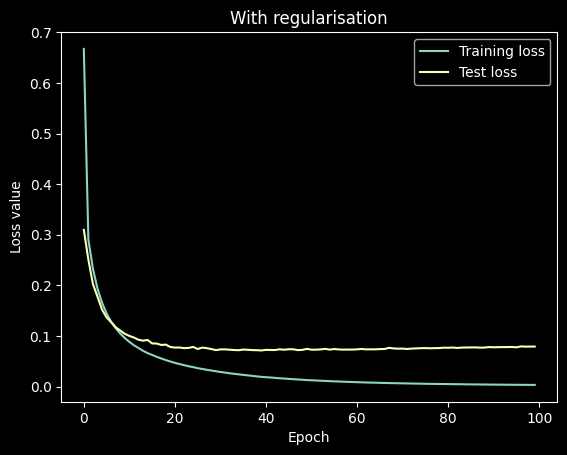

In [96]:
# Plot training loss as a function of epoch:
plt.title("With regularisation")
plt.plot(loss_train_epoch_r, label = 'Training loss')
plt.plot(loss_test_epoch_r, label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.show()

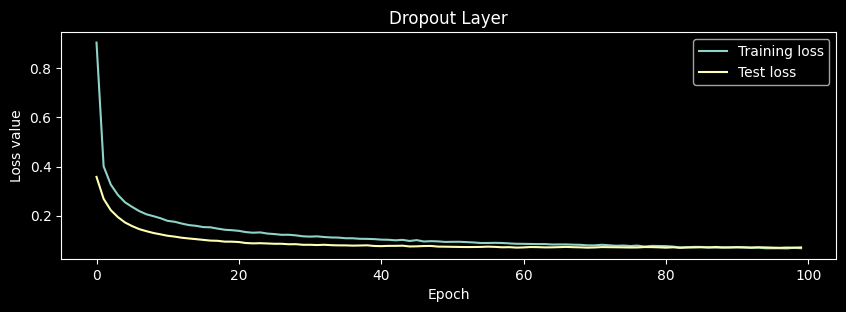

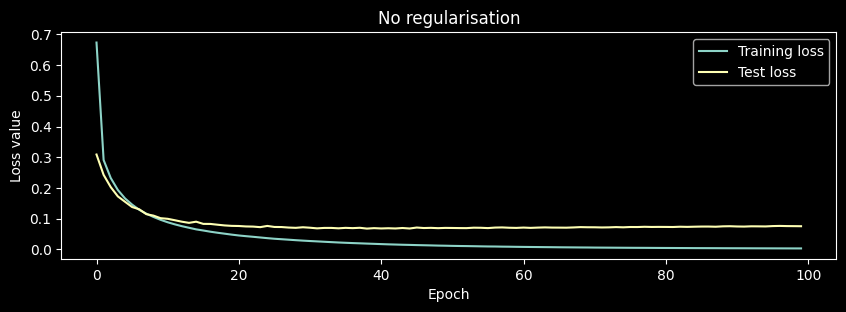

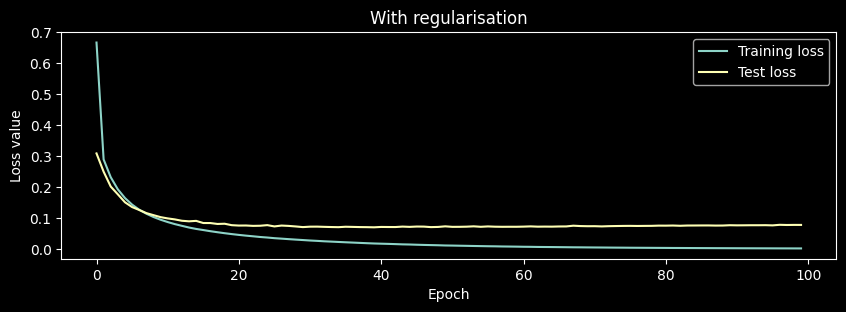

In [99]:
plt.figure(figsize=(10, 10))


plt.subplot(3,1,1)
plt.title("Dropout Layer")
plt.plot(loss_train_epoch, label = 'Training loss')
plt.plot(loss_test_epoch, label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(3,1,2)
plt.title("No regularisation")
plt.plot(loss_train_epoch_nr, label = 'Training loss')
plt.plot(loss_test_epoch_nr, label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(3,1,3)
plt.title("With regularisation")
plt.plot(loss_train_epoch_r, label = 'Training loss')
plt.plot(loss_test_epoch_r, label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.show()